# MIDOG++ Demo: Investigating Class Separability in Object Detection Models
Welcome to the **MIDOG++ Demo Notebook!** This notebook is designed to demonstrate the use of the **Hellinger Distance Value (HDV)** for evaluating class separability in object detection models, specifically using the **YOLOv7-D6** architecture on the **MIDOG++ dataset**.

## What you will learn in this demo
In this notebook, we will guide you through the following steps:

1. Setup the environment to run this notebook.

2. Download and prepare the MIDOG++ dataset.

3. Training a YOLOv7-D6 Model. Learn how to train a YOLOv7-D6 model on the HBC cases of the MIDOG++ dataset. *(Pre-trained weights are also provided if you prefer to skip the training process.)*

4. Evaluate your model on the MIDOGpp test cases to get performance metrics.

3. Extract features from the trained YOLOv7-D6 model to analyze its latent space.

6. Computing the HDV metric and visualizing the results to gain insights into the model's discriminative power and its behavior across different layers and coordinates.

## 1. Setup the environment
Follow the instructions in the `README` under the `Getting started` section before running this notebok. Then switch to the new kernel in the notebook. Go to the top menu and select: 
- `Kernel > Change Kernel > demo_env`

Verify the environment:


In [1]:
import sys
print(f"Current Python executable: {sys.executable}")
!pip list

Current Python executable: /home/ammeling/projects/yolov7/demo_env/bin/python


Package                       Version
----------------------------- --------------------
absl-py                       2.1.0
alabaster                     1.0.0
albucore                      0.0.23
albumentations                1.3.1
annotated-types               0.7.0
anyio                         4.8.0
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asciitree                     0.3.3
astropy                       6.1.7
astropy-iers-data             0.2025.1.31.12.41.4
asttokens                     3.0.0
async-lru                     2.0.4
attrs                         25.1.0
babel                         2.17.0
beautifulsoup4                4.12.3
bleach                        6.2.0
blinker                       1.9.0
bokeh                         3.5.2
cattrs                        24.1.2
certifi                       2025.1.31
cffi                          1.17.1
charset-normalizer            3.4.1
click                

## 2. Download the MIDOG++ dataset
First we need to download the data. The total size of the dataset is 65 GB so running the script can take a while. The recommended location for the downloaded files is at `images`. If you want to specify your own location you will have to adapt it later on in this notebook. 

In [2]:
# Download MIDOG++ to images/
!python download_midogpp.py --location images

2025-02-10 10:19:35 - INFO - 
###########################################################################################################################

This script downloads the MIDOGpp dataset. The total size of the dataset is 65 GB so running the script might take a while.

###########################################################################################################################

2025-02-10 10:19:35 - INFO - Images will be stored at: images.
2025-02-10 10:19:35 - INFO - Start downloading.
  0%|                                                   | 0/505 [00:00<?, ?it/s]2025-02-10 10:19:35 - INFO - File already exists: 40282102.
2025-02-10 10:19:35 - INFO - File already exists: 40282099.
2025-02-10 10:19:35 - INFO - File already exists: 40282096.
2025-02-10 10:19:35 - INFO - File already exists: 40282105.
2025-02-10 10:19:35 - INFO - File already exists: 40282111.
2025-02-10 10:19:35 - INFO - File already exists: 40282108.
2025-02-10 10:19:35 - INFO - File already ex

Next, we want to prepare the MIDOG++ dataset for training, validation and testing. For this demo, we will train and evaluate only on the HBC cases. Testing and feature extraction will be performed on all other cases. We will take the provided json file and split the HBC cases randomly to train, val and test using a 60/20/20 split. All non-HBC cases go to the test set by default. 

In [3]:
import json
import pandas as pd

def create_demo_datasets(json_file):
    """Converts the MIDOG++ json file to pandas dataframe with human breast cancer samples in all splits."""
    database = json.load(open(json_file, 'rb'))

    # Read image data
    image_df = pd.DataFrame.from_dict(database['images'])
    image_df = image_df.drop(columns=['license', 'width', 'height'])
    image_df = image_df.rename({'id':'image_id', 'tumor_type':'tumortype', 'file_name':'filename'}, axis=1)

    # Create train, val, test splits including HBC in test set
    random_seed = 42
    hbc_df = image_df.query('tumortype == "human breast cancer"')

    # Split HBC data: 60% train, 20% valid, 20% test
    train_ids = hbc_df.sample(frac=0.6, random_state=random_seed)['image_id']
    remaining_hbc = hbc_df[~hbc_df['image_id'].isin(train_ids)]
    valid_ids = remaining_hbc.sample(frac=0.5, random_state=random_seed)['image_id']
    test_hbc_ids = remaining_hbc[~remaining_hbc['image_id'].isin(valid_ids)]['image_id']

    # Assign splits
    image_df['split'] = 'test'  # All non-HBC samples go to test by default
    image_df.loc[image_df['image_id'].isin(train_ids), 'split'] = 'train'
    image_df.loc[image_df['image_id'].isin(valid_ids), 'split'] = 'val'
    image_df.loc[image_df['image_id'].isin(test_hbc_ids), 'split'] = 'test'

    # Read annotations
    annotations_df = pd.DataFrame.from_dict(database['annotations'])
    annotations_df = annotations_df.assign(x=annotations_df['bbox'].apply(lambda x: int((x[0] + x[2]) / 2)))
    annotations_df = annotations_df.assign(y=annotations_df['bbox'].apply(lambda x: int((x[1] + x[3]) / 2)))
    annotations_df = annotations_df.drop(columns=['bbox', 'labels', 'id'])

    # Merge data, rename and rearrange
    comb_df = image_df.merge(annotations_df, how='right', on='image_id')
    comb_df = comb_df.rename({'category_id': 'label', 'image_id': 'slide'}, axis=1)
    comb_df = comb_df[['x', 'y', 'label', 'filename', 'slide', 'split', 'tumortype']]

    return comb_df

In [17]:
from pathlib import Path 

# Set the path to the downloaded images 
img_dir = Path('images')
json_file = img_dir / 'MIDOGpp.json'

# Create the demo dataset 
demo_ds = create_demo_datasets(json_file)

# Save the demo dataset
demo_ds.to_csv(img_dir.joinpath('MIDOGpp_demo.csv'))

Lets have a brief look at the dataset! 

In [5]:
# The number of files per train, val, test split
print(demo_ds.groupby('split')['filename'].nunique())

split
test     379
train     93
val       31
Name: filename, dtype: int64


So in our demo dataset, there are 93 HBC cases in the training set, 31 HBC cases in the validation set, and all other 379 cases are in the test set. 

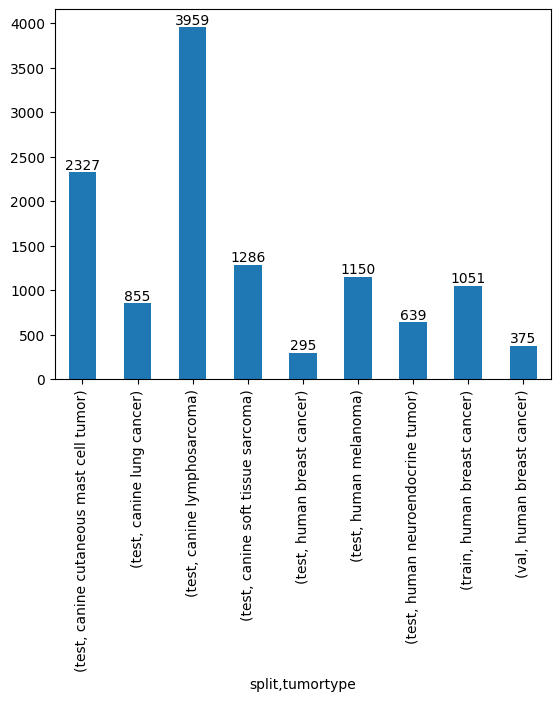

In [6]:
import matplotlib.pyplot as plt

ax = demo_ds.query('label == 1').groupby(['split', 'tumortype']).size().plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.show()

Looking at the distribution of mitotic figures (MFs) across the tumortypes and datasets, we can see that we have 1000 MFs for training and about 375 for evaluation on the HBC cases. Looking at the test set, we have 295 remaining MFs of the HBC cases. The most MFs with 3959 samples are come from the canine lymphosarcoma (CLYM). Second most MFs come from the canine cutaneous mast cell tumor (CCMCT) with 2327 samples. The least amount of MFs from an unseen domain are found in the human neuroendocrine tumor (HNET) cases with 639 cases. The canine soft tissue sarcoma cases (CSTS) are new cases that were not part of previous MIDOG datasets. The human melanoma cases (HMEL) were part of the MIDOG 2022 challenge, however they were provided unlabelled during the challenge. 

Let's look at some examples from the different domains. 

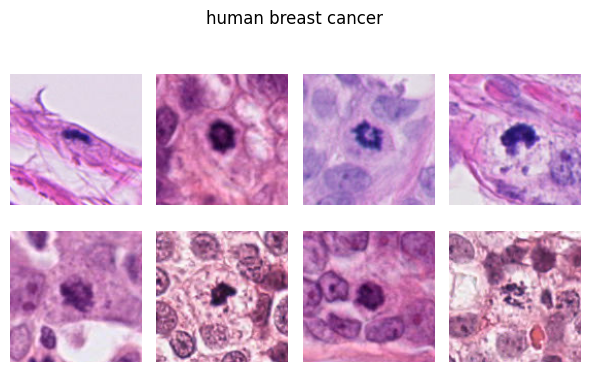

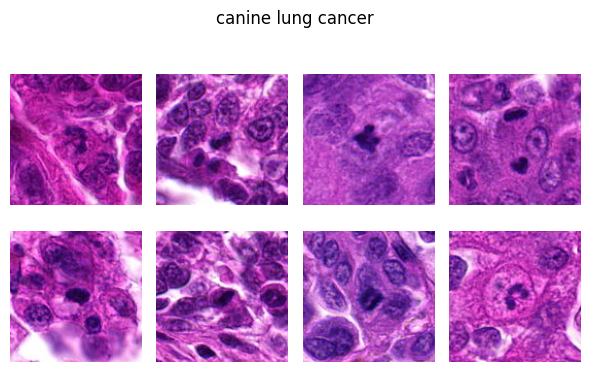

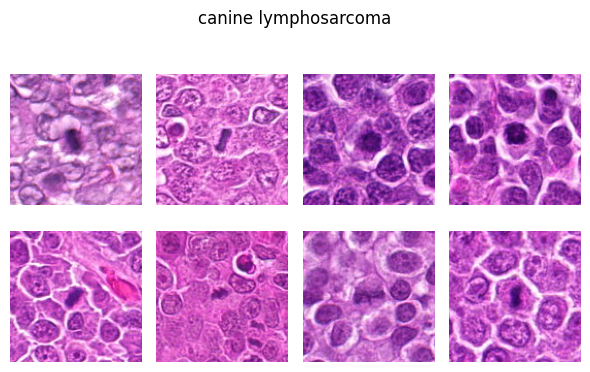

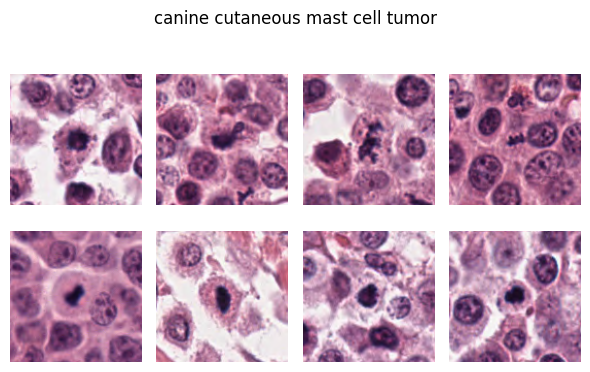

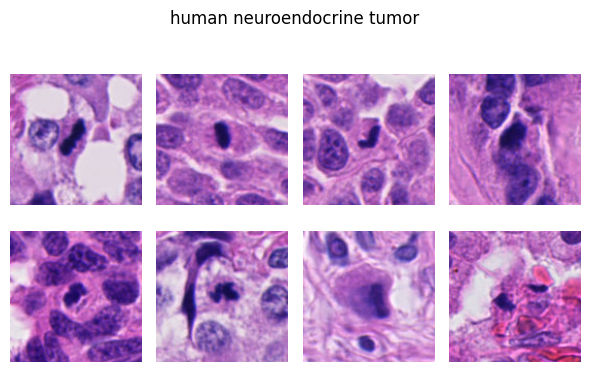

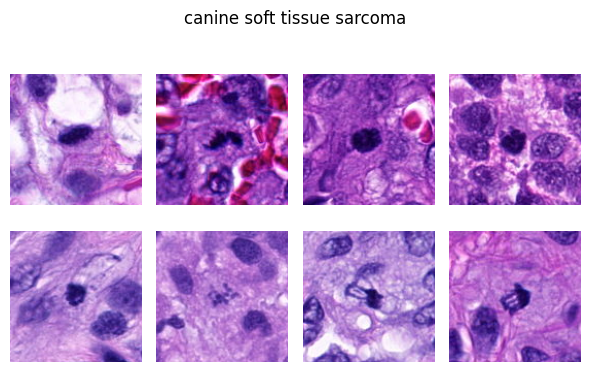

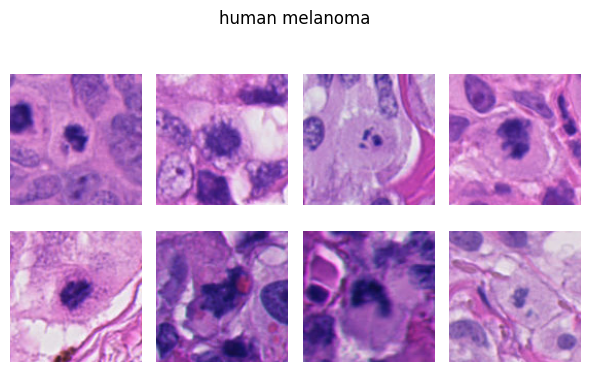

In [7]:
from PIL import Image 
from pathlib import Path 

img_dir = Path('images')
tumor_types = demo_ds.tumortype.unique().tolist()
size = 128

for tumor_type in tumor_types:
    tumor_samples = demo_ds.query('label == 1 & tumortype == @tumor_type').sample(n=8)
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(6,4))
    for idx, ax in enumerate(axs.flatten()):
        x, y, filename = tumor_samples.iloc[idx][['x', 'y', 'filename']]
        img = Image.open(img_dir / filename)
        patch = img.crop([x-size/2, y-size/2, x+size/2, y+size/2])
        ax.imshow(patch)
        ax.axis('off')
    plt.suptitle(tumor_type)
    plt.tight_layout()
    plt.show()


## 3. Train your own YOLOv7-D6
We adapted the official YOLOv7 implementation to deal with our online sampling approach. You can either decide to train your own YOLOv7 model, or you can skip this step and use the weights that we provided.

### Train you own YOLOv7 model

If you want to train your own model, you can use the commands the below. This will train a YOLOv7-D6 using a batch size of 6 with a patch size of 1280x1280 for 100 epochs and 512 samples per epoch which needs about 23.1 GB of GPU memory. The model will be saved to `runs/train/yolov7d6_demo`. You may need to login to to your wandb account. ***If you want to skip this step head over to the next section (4.).***

In [8]:
!python3 train_aux.py --cfg cfg/training/yolov7-d6-midog.yaml --data data/midog.yaml --img_dir images/ --dataset images/midogpp_demo.csv --batch-size 6 --img-size 1280 1280 --weights yolov7-d6_training.pt --name test --adam --hyp data/hyp.scratch.custom.yaml --gradient_clip_norm 5 --sampling_strategy default --epochs 2 --noautoanchor --num_samples 512

|2025-02-03|16:08:06.612| [INFO] YOLOR 🚀 8e4ae58 torch 2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24217.3125MB)

|2025-02-03|16:08:06.614| [INFO] Namespace(img_dir='images/', dataset='images/midogpp_demo.csv', box_format='cxcy', num_samples=512, sampling_strategy='default', gradient_clip_norm=5, fg_prob=0.5, arb_prob=0.25, weights='yolov7-d6_training.pt', cfg='cfg/training/yolov7-d6-midog.yaml', data='data/midog.yaml', hyp='data/hyp.scratch.custom.yaml', epochs=2, batch_size=6, img_size=[1280, 1280], rect=False, resume=False, nosave=False, notest=False, noautoanchor=True, evolve=False, bucket='', cache_images=False, image_weights=False, device='', multi_scale=False, single_cls=False, adam=True, sync_bn=False, local_rank=-1, workers=8, project='runs/train', entity=None, name='test', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', v5_metric=False, world_size=1, global_rank=-1, save_dir='r

If you trained your own model, we want to optimize its detection threshold for optimal performance. The following script will test the detection performance for a range of detection thresholds on the validation set and save the detection threshold with the best F1 score to the model configurations. The saved model configurations will be stored at `optimized_models/test.yaml`.

In [9]:
!python3 optimize_threshold.py --batch_size 6 --cfg cfg/training/yolov7-d6-midog.yaml --dataset_file images/midogpp_demo.csv --detector yolov7_d6 --img_dir images/ --model_name test --weights runs/train/test3/weights/best.pt

Initializing model ... |2025-02-10|14:37:46.040| [INFO] 
                 from  n    params  module                                  arguments                     
|2025-02-10|14:37:46.041| [INFO]   0                -1  1         0  models.common.ReOrg                     []                            
|2025-02-10|14:37:46.041| [INFO]   1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
|2025-02-10|14:37:46.042| [INFO]   2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
|2025-02-10|14:37:46.042| [INFO]   3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
|2025-02-10|14:37:46.042| [INFO]   4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
|2025-02-10|14:37:46.043| [INFO]   5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]             

## 4. Evaluate a YOLOv7-D6 on the MIDOGpp dataset

We can use the optimized models to evaluate the performance on the unseen test domains of our dataset. You can either use your own model that you just trained in the previous steps or use our provided model from `optimized_models/yolov7_d6_demo.yaml`.

In [11]:
# select the config_file that you would like to evaluate
!python3 evaluate.py --config_file optimized_models/yolov7_d6_demo.yaml --dataset_file images/midogpp_demo.csv --img_dir images/ --overwrite

Initializing model ... |2025-02-10|16:02:24.334| [INFO] 
                 from  n    params  module                                  arguments                     
|2025-02-10|16:02:24.334| [INFO]   0                -1  1         0  models.common.ReOrg                     []                            
|2025-02-10|16:02:24.335| [INFO]   1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
|2025-02-10|16:02:24.336| [INFO]   2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
|2025-02-10|16:02:24.336| [INFO]   3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
|2025-02-10|16:02:24.336| [INFO]   4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
|2025-02-10|16:02:24.336| [INFO]   5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]             

If you did not select a specific output file. We can view the results with the following:

In [31]:
import json

def load_metrics(
        filename: str, 
        metric: str, 
        ):
    """
    Load specific metrics from result file.

    Args:
        filename (str): Path to the JSON file containing metrics.
        metric (str): The metric suffix to filter (e.g., '_accuracy').

    Returns:
        tuple: A dictionary of filtered metrics and the full metric data.
    """
    all_metric_data = json.load(open(filename, 'rb'))
    aggregates = all_metric_data['aggregates']
    metric_dict = {}

    # filter the aggregate metrics 
    for key in aggregates:
        if key.startswith('tumor') and key.endswith(metric):
            tumor = key.split('_')[1]
            metric_dict[tumor] = aggregates[key]
            
    return metric_dict

In [34]:
import json
from pprint import pprint

# Enter result file 
result_file = 'results/yolov7_d6_demo.json'

# Open result file
f1_scores = load_metrics(result_file, metric='f1')

# Show f1 results 
pprint(f1_scores)

{'caninecutaneousmastcelltumor': 0.7258382643673968,
 'caninelungcancer': 0.23880597090666073,
 'caninelymphosarcoma': 0.18960802206253233,
 'caninesofttissuesarcoma': 0.5723014258796836,
 'humanbreastcancer': 0.7131782951294994,
 'humanmelanoma': 0.7201125177120898,
 'humanneuroendocrinetumor': 0.5074626869540748}


For our demo model, we can see that the model performs best on the CCMCT, HBC, and HMEL cases with F1-Scores greater than 0.7. Our demo model performs worst on the CLYM cases with an F1-Score of 0.1896.

## 5. Extract features from the test cases

In order to calculate the HDV metric we need to extract the features from our objects in the test domains. You can either extract the features for your own model or use our demo model. Extracting the features may take a while. The results will be saved to `demo_results/`. 

In [36]:
# If you want to extract features of your own model specifiy the config file
!python3 extract_features.py --config_file optimized_models/yolov7_d6_demo.yaml --save_path demo_results --batch_size 16 --dataset_file images/MIDOGpp_demo.csv --img_dir images/

Initializing model ... |2025-02-10|20:07:15.195| [INFO] 
                 from  n    params  module                                  arguments                     
|2025-02-10|20:07:15.195| [INFO]   0                -1  1         0  models.common.ReOrg                     []                            
|2025-02-10|20:07:15.196| [INFO]   1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
|2025-02-10|20:07:15.196| [INFO]   2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
|2025-02-10|20:07:15.197| [INFO]   3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
|2025-02-10|20:07:15.197| [INFO]   4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
|2025-02-10|20:07:15.197| [INFO]   5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]             

## 6. Calculate the HDV 